# Solution for the first science case

In [1]:
#########################################
# Author: Eduardo Alberto Duarte Lacerda
# E-mail: dhubax@gmail.com
#########################################

# needed Python imports
# imports for data retrieve
import lsdb
import splusdata
from dask.distributed import Client
# imports for plot and calculation
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy as copy

# auxiliar functions and variables

# https://github.com/splus-collab/splus_filters for S-PLUS filters information
splus_bands = [
    'u', 'J0378', 'J0395', 'J0410', 'J0430', 
    'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z',
]
# pivot wavelenght of S-PLUS filters 
splut_bands_pivot_wavelenghts = [
    3533.28, 3773.16, 3940.7, 4094.93, 
    4292.11, 4758.49, 5133.13, 6251.83, 
    6613.88, 7670.61, 8607.25, 8941.48
]

## Read catalogs using LSDB

### Start Dask client

In [2]:
# Start a Dask client for the parallel process used by lsdb
max_cpu = 8
max_mem = '6GB'
client = Client(n_workers=max_cpu, memory_limit=max_mem)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 20,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38613,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:36303,Total threads: 2
Dashboard: http://127.0.0.1:39379/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:34143,


## S-PLUS Catalogs choice

In [67]:
# search for the full S-PLUS DR4/dual mode catalog
dr4psf_search = splusdata.get_hipscats('dr4/psf')

# Print all catalogs found with the pattern above
print(f'dr4/dual search: {dr4dual_search}')

# select the first catalog found
dr4psf_hipscat, dr4psf_margin_cache_hipscat = dr4psf_search[0]

# Create the columns list to retrieve only necessaries columns
'''/
We use here choose the magnitudes from 'PStotal' apperture mode.

Read mode about:
     https://splus.cloud/documentation/DR4?Photometry
'''
columns = ['ID', 'RA', 'DEC'] 

apperture = 'psf'
columns += [f'{b}_{apperture}' for b in splus_bands] 
columns += [f's2n_{b}_{apperture}' for b in splus_bands]
columns += [f'CLASS_STAR_{b}' for b in ['u', 'g', 'r', 'i', 'z']]

dr4/dual search: [['https://splus.cloud/HIPS/catalogs/dr4/psf/', 'https://splus.cloud/HIPS/catalogs/dr4/psf_2arcsec/']]


### Read DR4/dual and QSO/star/galaxy catalogs

In [68]:
# Read more about the need of the margin cache server at:
#      https://lsdb.readthedocs.io/en/stable/tutorials/margins.html    
dr4psf_margin = lsdb.read_hipscat(dr4psf_margin_cache_hipscat)

# Read DR4 dual HiPSCAT
dr4psf = lsdb.read_hipscat(
    dr4psf_hipscat,
    margin_cache=dr4psf_margin,
    # Read more about the available columns at:
    #      https://splus.cloud/documentation/DR4?Schemas,_tables_and_columns
    columns=columns,
)

# GAIA DR3 HiPSCat
gaia = lsdb.read_hipscat(
    'https://data.lsdb.io/unstable/gaia_dr3/gaia/',
    margin_cache='https://data.lsdb.io/unstable/gaia_dr3/gaia_10arcs/',
    columns=[
        'source_id',
        'ra',
        'dec',
        'parallax',
        'parallax_error',
        'pmra',
        'pmdec',
        #'pmra_error',
        #'pmdec_error',
        #'radial_velocity',
        #'radial_velocity_error', 
        #'ruwe',
    ],
)

## Perform the crossmatch

In [69]:
dr4psfgaia_crosmatch = dr4psf.crossmatch(gaia, suffixes=['_gaia', '_dr4psf'], radius_arcsec=1)

In [1]:
dr4psfgaia_crosmatch.plot_pixels('DR4PSF - GAIA DR3 crossmatch')

NameError: name 'dr4psfgaia_crosmatch' is not defined

## Search for objects using the crossmatch result table

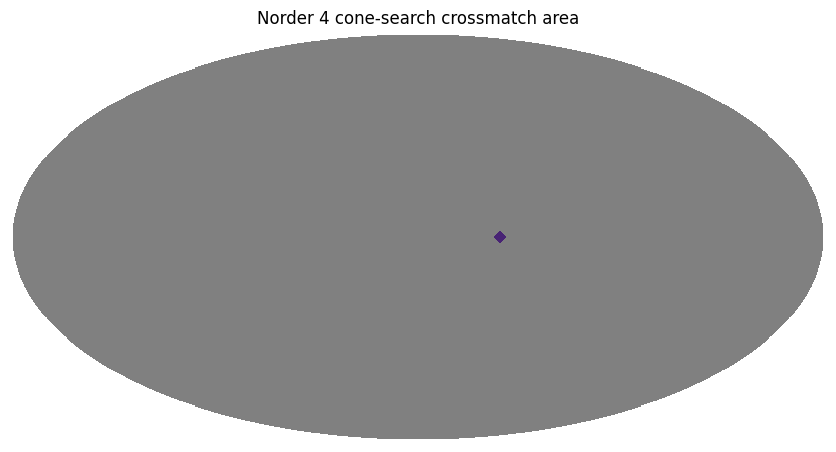

In [71]:
# Let's get the resultant table:
cone_center_coord = (323.36249, -0.82333) # RA and DEC in degrees
cone_radius = 30*60 # arcsec
objects_table_crossmatch = dr4psfgaia_crosmatch.cone_search(ra=cone_center_coord[0], dec=cone_center_coord[1], radius_arcsec=cone_radius)
#objects_table_crossmatch = dr4dualsqg_crosmatch.box_search([323, 324], [-1.3, -0.5])
objects_table_crossmatch.plot_pixels('cone-search crossmatch area')

In [72]:
objects_table = objects_table_crossmatch.compute()

In [73]:
objects_table.columns

Index(['ID_dr4psf', 'RA_dr4psf', 'DEC_dr4psf', 'u_psf_dr4psf',
       'J0378_psf_dr4psf', 'J0395_psf_dr4psf', 'J0410_psf_dr4psf',
       'J0430_psf_dr4psf', 'g_psf_dr4psf', 'J0515_psf_dr4psf', 'r_psf_dr4psf',
       'J0660_psf_dr4psf', 'i_psf_dr4psf', 'J0861_psf_dr4psf', 'z_psf_dr4psf',
       's2n_u_psf_dr4psf', 's2n_J0378_psf_dr4psf', 's2n_J0395_psf_dr4psf',
       's2n_J0410_psf_dr4psf', 's2n_J0430_psf_dr4psf', 's2n_g_psf_dr4psf',
       's2n_J0515_psf_dr4psf', 's2n_r_psf_dr4psf', 's2n_J0660_psf_dr4psf',
       's2n_i_psf_dr4psf', 's2n_J0861_psf_dr4psf', 's2n_z_psf_dr4psf',
       'CLASS_STAR_u_dr4psf', 'CLASS_STAR_g_dr4psf', 'CLASS_STAR_r_dr4psf',
       'CLASS_STAR_i_dr4psf', 'CLASS_STAR_z_dr4psf', 'source_id_gaia',
       'ra_gaia', 'dec_gaia', 'parallax_gaia', 'parallax_error_gaia',
       'pmra_gaia', 'pmra_error_gaia', 'pmdec_gaia', 'pmdec_error_gaia',
       'radial_velocity_gaia', 'radial_velocity_error_gaia', 'ruwe_gaia',
       '_dist_arcsec'],
      dtype='object')

<hr>

## Create plots

###  Spatial distribution plot

Text(0.5, 0, 'DEC')

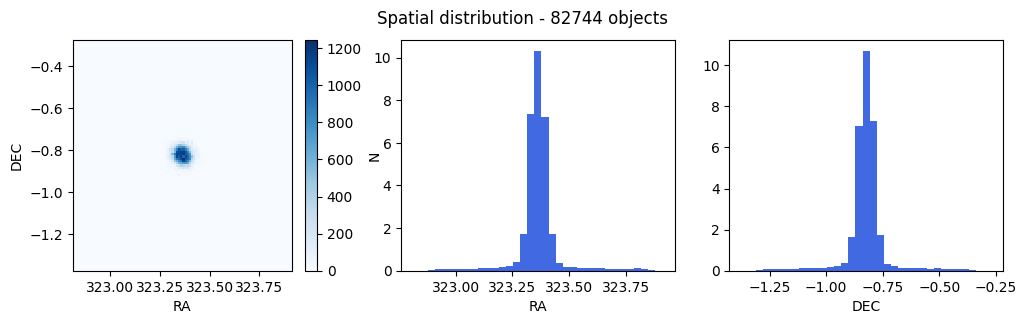

2024-09-20 18:13:35,273 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-09-20 18:13:35,273 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/asyncio/base_events.py", line 687, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/home/lacerda/.pyenv/versions/dev/lib/python3.12/site-packages/distributed/nanny.py", line 984, in run
    await worker.finished()
  File "/home/lacerda/.pyenv/versions/dev/lib/python3.12/site-packages/distributed/core.py", line 491, in finished
    await self._event_finished.wait()
  File "/usr/lib/python3.12/asyncio/locks.py", line 212, in wait
    await fut
as

In [116]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(12, 3)
N = len(objects_table)
f.suptitle(f'Spatial distribution - {N} objects')
ra = objects_table['RA_dr4psf']
dec = objects_table['DEC_dr4psf']
x = cone_radius/3600
ra_range = cone_center_coord[0]+np.array([-1.1*x, 1.1*x])
dec_range = cone_center_coord[1]+np.array([-1.1*x, 1.1*x])
_, _, _, im1 = ax1.hist2d(ra, dec, bins=100, range=[ra_range, dec_range], cmap='Blues')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
cax = plt.colorbar(im1, ax=ax1)
cax.ax.set_ylabel('N')
ax2.hist(ra, bins=35, range=ra_range, density=True, color='royalblue', histtype='stepfilled')
ax2.set_xlabel('RA')
ax3.hist(dec, bins=35, range=dec_range, density=True, color='royalblue', histtype='stepfilled')
ax3.set_xlabel('DEC')

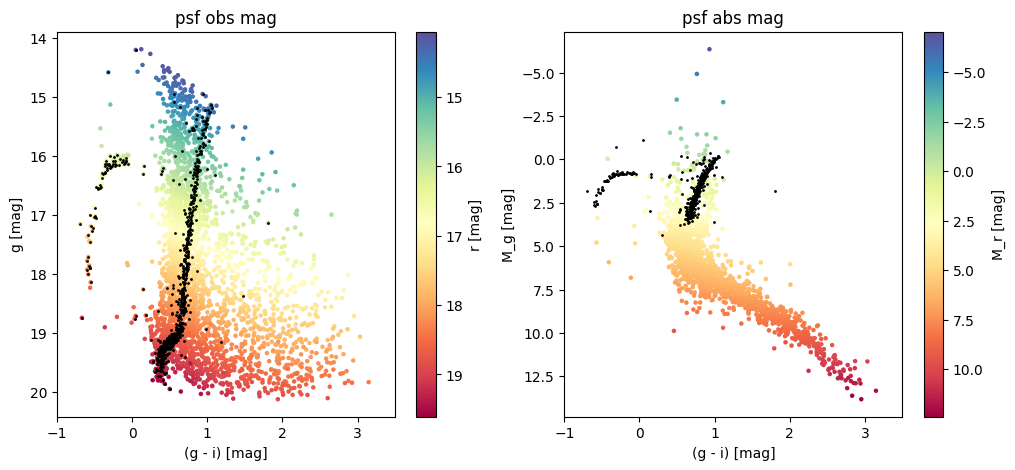

In [107]:
suffix = '_dr4psf'

# quality mask
mask = (objects_table[f's2n_g_{apperture}{suffix}'] > 30)
mask &= (objects_table[f's2n_g_{apperture}{suffix}'] < 1000)
mask &= (objects_table[f's2n_i_{apperture}{suffix}'] > 30)
mask &= (objects_table[f's2n_i_{apperture}{suffix}'] < 1000)
for band in ['r', 'g', 'i']:
    mask = np.bitwise_and(mask, objects_table[f'{band}_{apperture}{suffix}'] > 14)
    mask = np.bitwise_and(mask, objects_table[f'{band}_{apperture}{suffix}'] < 21)

# Messier 2 proper motion mask (cluster selection)
pmra, pmdec = 3.5, -2.15
maskm2 = objects_table['pmra_gaia'] > (pmra - 0.5)
maskm2 &= objects_table['pmra_gaia'] < (pmra + 0.5)
maskm2 &= objects_table['pmdec_gaia'] > (pmdec - 0.5)
maskm2 &= objects_table['pmdec_gaia'] < (pmdec + 0.5)

x = objects_table[f'g_{apperture}{suffix}'] - objects_table[f'i_{apperture}{suffix}']
y = objects_table[f'g_{apperture}{suffix}']
z = objects_table[f'r_{apperture}{suffix}']

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(12, 5)
im = ax1.scatter(x[mask], y[mask], c=z[mask], s=5, cmap='Spectral_r')
ax1.scatter(x[mask & maskm2], y[mask & maskm2], s=1, c='k')
ax1.set_title(f'{apperture} obs mag')
cax = plt.colorbar(im, ax=ax1)
cax.ax.set_ylabel('r [mag]')
cax.ax.invert_yaxis()
ax1.set_xlabel(f'(g - i) [mag]')
ax1.set_ylabel(f'g [mag]')
ax1.set_xlim(-1, 3.5)
ax1.invert_yaxis()

par = objects_table['parallax_gaia']
epar = objects_table['parallax_error_gaia']
m2mabs_corr = -5*np.log10(11500) + 5
mabs_corr = -5*np.log10(1/(par*0.001)) + 5

mask &= (epar < 0.2)
y1 = copy(y) + mabs_corr
z = copy(z) + mabs_corr

y2 = copy(y) + m2mabs_corr

im = ax2.scatter(x[mask & ~maskm2], y1[mask & ~maskm2], c=z[mask & ~maskm2], s=5, cmap='Spectral_r')

ax2.scatter(x[mask & maskm2], y2[mask & maskm2], s=1, c='k')
ax2.set_title(f'{apperture} abs mag')
cax = plt.colorbar(im, ax=ax2)
cax.ax.set_ylabel('M_r [mag]')
cax.ax.invert_yaxis()
ax2.set_xlabel(f'(g - i) [mag]')
ax2.set_ylabel(f'M_g [mag]')
ax2.set_xlim(-1, 3.5)
ax2.invert_yaxis()